In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [3]:
%cd /content/gdrive/MyDrive/Detectron2/Road_Sign

/content/gdrive/MyDrive/Detectron2/Road_Sign


In [4]:
!pip install pyyaml==5.1

import torch

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

print("Torch : ", TORCH_VERSION, " ,  Cuda : ", CUDA_VERSION)
!python -m pip install "git+https://github.com/facebookresearch/detectron2.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 9.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Torch :  2.6  ,  Cuda :  cu124
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vll3q6j3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vll3q6j3
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os,json,random,cv2
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
!pwd

/content/gdrive/MyDrive/Detectron2/Road_Sign


In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("CustomTrain1",{},"./annotations.json","./train")

In [8]:
sample_metadata = MetadataCatalog.get("CustomTrain1")
dataset_dicts = DatasetCatalog.get("CustomTrain1")

WARNING [05/06 16:33:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/06 16:33:24 d2.data.datasets.coco]: Loaded 613 images in COCO format from ./annotations.json


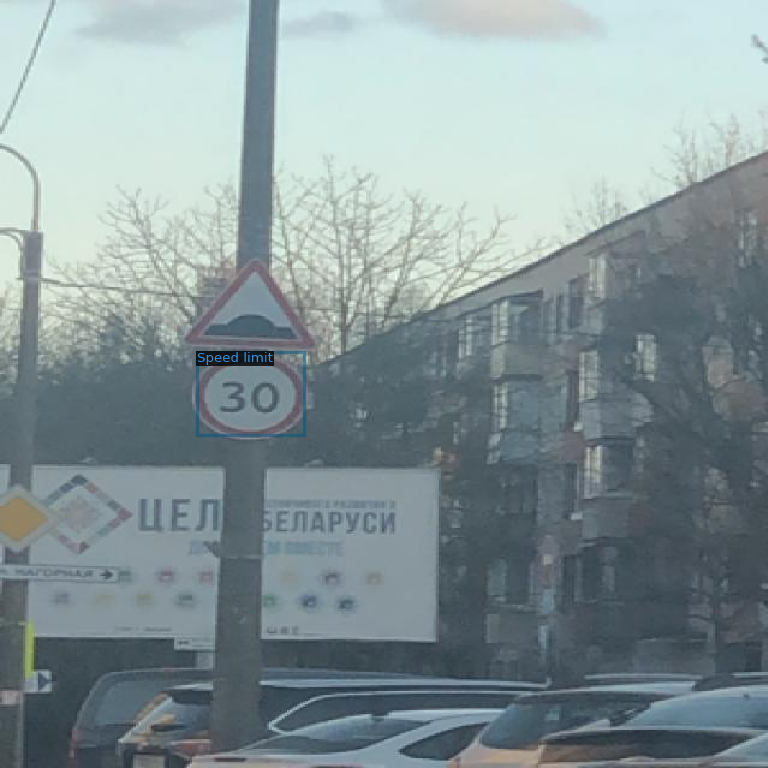

In [9]:
import random

for d in random.sample(dataset_dicts,1):
  img=cv2.imread(d["file_name"])
  visualizer=Visualizer(img[:,:,::-1],metadata=sample_metadata,scale=1.2)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:,:,::-1])

In [14]:
from detectron2.engine import DefaultTrainer

cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN=("CustomTrain1",)
cfg.DATASETS.TEST=()
cfg.DATALOADER.NUM_WORKERS=2
cfg.MODEL_WEIGHTS=model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH=2
cfg.SOLVER.BASE_LR=0.0025
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE=128
cfg.MODEL.ROI_HEADS.NUM_CLASSES=4
cfg.MODEL.ROI_HEADS.NMS=0.1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()


[05/06 16:35:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  #setting the threshold value
cfg.DATASETS.TEST = ("CustomTrain1",)
predictor = DefaultPredictor(cfg)


[05/06 16:35:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


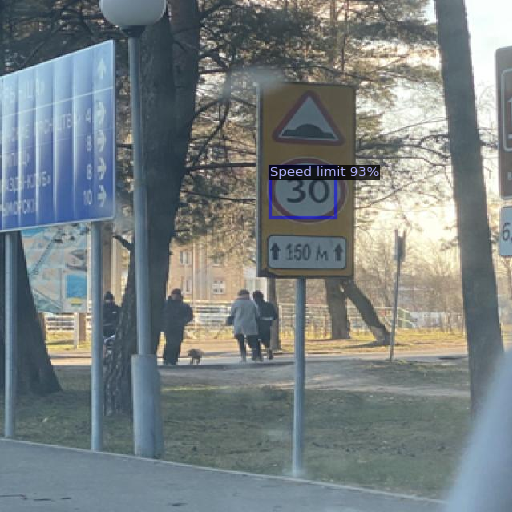

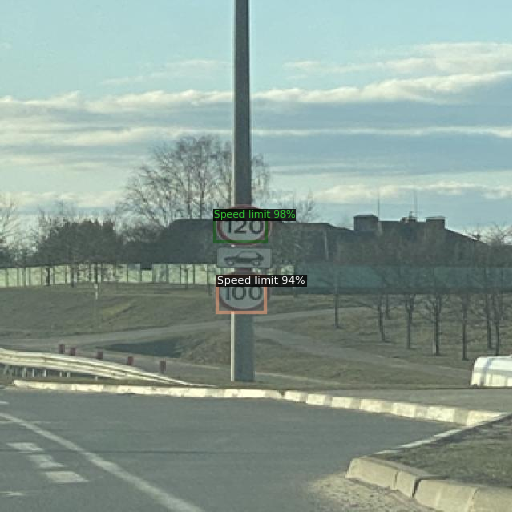

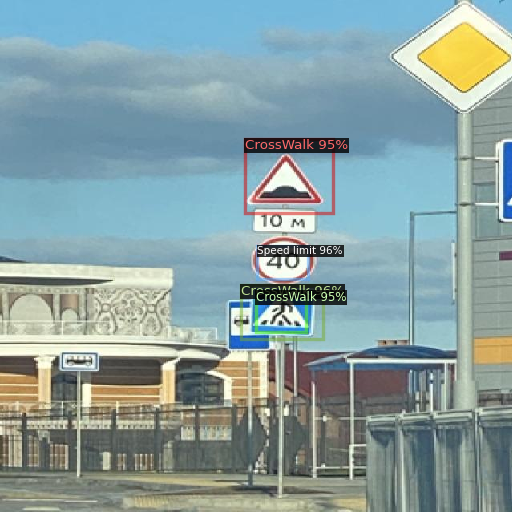

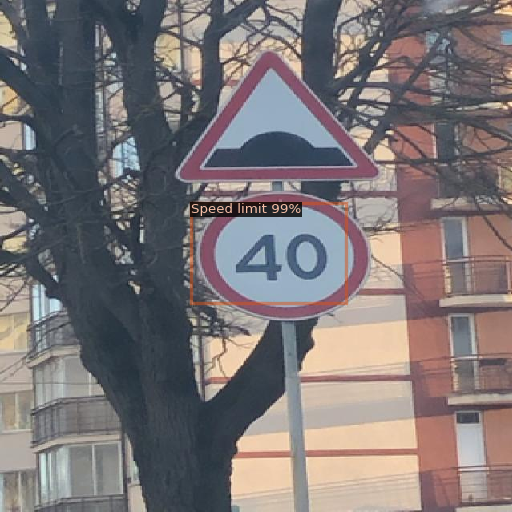

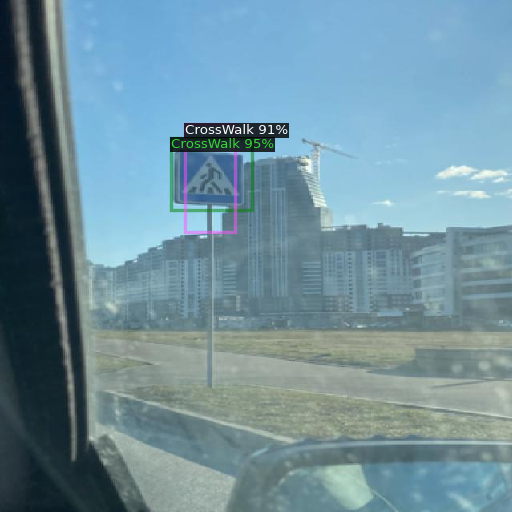

In [18]:
import random

for d in random.sample(dataset_dicts,5):
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  v=Visualizer(im[:,:,::-1],metadata=sample_metadata,scale=0.8)
  v=v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:,:,::-1])